In [2]:
!pip install vrplib

  Using cached vrplib-1.5.1-py3-none-any.whl.metadata (10 kB)
Using cached vrplib-1.5.1-py3-none-any.whl (24 kB)


In [7]:
!pip install openai

In [11]:
# 安装最新版openai（1.0.0+）
!pip install openai --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.0/599.0 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 0.28.0
    Uninstalling openai-0.28.0:
      Successfully uninstalled openai-0.28.0


In [ ]:
import re
import os
import vrplib
import random
import matplotlib.pyplot as plt
import requests


# Read all instances
def read_all_instances(root_folder, ending='.tsp'):
    instances = []

    def extract_k_and_n_numbers(file_name):
        # Extract 'k' and 'n' numbers from the file name
        k_match = re.search(r'k(\d+)', file_name)
        n_match = re.search(r'n(\d+)', file_name)

        # If both matches are successful, return a tuple of (k, n)
        k = int(k_match.group(1)) if k_match else float('inf')
        n = int(n_match.group(1)) if n_match else float('inf')
        return k, n

    # Sort the file names according to (k, n)
    file_names = sorted(
        [file_name for file_name in os.listdir(root_folder) if file_name.endswith(ending)],
        key=extract_k_and_n_numbers
    )

    for file_name in file_names:
        instance = vrplib.read_instance(os.path.join(root_folder, file_name))
        if instance:
            instances.append(instance)
            print(f'Successfully read {file_name}')
        else:
            print(f'Failed to read {file_name}')

    return instances


# Define a function to visualize the solution
def plot_CVRP_solution(routes, node_coords):
    plt.figure(figsize=(10, 8))

    # Plot the nodes
    for i, (x, y) in enumerate(node_coords):
        plt.scatter(x, y, c='blue' if i == 0 else 'red')
        plt.text(x, y, f'{i}', fontsize=9, horizontalalignment='right')

    # Plot the routes
    colors = ['b', 'g', 'r', 'c','m', 'y', 'k']
    for vehicle, route in enumerate(routes):
        route_coords = [node_coords[0]] + [node_coords[node] for node in route] + [node_coords[0]]
        x_coords, y_coords = zip(*route_coords)
        plt.plot(x_coords, y_coords, c=colors[vehicle % len(colors)], label=f'Vehicle {vehicle + 1}')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routing Problem Solution')
    plt.legend()
    plt.grid(True)
    plt.show()


# Define a function to test the vehicle capacity constraint
def test_capacity_constraint(routes, demands, vehicle_capacity):
    for vehicle, route in enumerate(routes):
        total_demand = sum(demands[node] for node in route)
        if total_demand > vehicle_capacity:
            print(f"Vehicle {vehicle + 1} exceeds capacity: {total_demand} > {vehicle_capacity}")
        else:
            print(f"Vehicle {vehicle + 1} is within capacity: {total_demand} <= {vehicle_capacity}")


# Define a function to calculate the route distance
def calculate_route_distance(route, distance_matrix):
    distance = 0
    if route:
        distance += distance_matrix[0][route[0]]  # From the depot to the first node
        for i in range(1, len(route)):
            distance += distance_matrix[route[i - 1]][route[i]]
        distance += distance_matrix[route[-1]][0]  # From the last node back to the depot
    return distance


# Define a function to calculate the total distance of all routes (CVRP)
def total_distance(routes, distance_matrix):
    return sum(calculate_route_distance(route, distance_matrix) for route in routes)


# Generate an initial solution using the greedy method
def greedy_initial_solution(distance_matrix, demands, num_vehicles, vehicle_capacity, num_nodes):
    routes = [[] for _ in range(num_vehicles)]
    current_load = [0] * num_vehicles
    visited = [False] * num_nodes
    visited[0] = True  # Start from the depot

    for vehicle in range(num_vehicles):
        current_node = 0
        while True:
            next_node = None
            min_distance = float('inf')
            for i in range(1, num_nodes):
                if not visited[i] and current_load[vehicle] + demands[i] <= vehicle_capacity:
                    if distance_matrix[current_node][i] < min_distance:
                        min_distance = distance_matrix[current_node][i]
                        next_node = i
            if next_node is None:
                break
            routes[vehicle].append(next_node)
            current_load[vehicle] += demands[next_node]
            visited[next_node] = True
            current_node = next_node
    return routes


# Destroy the solution
def destroy_solution(routes, num_customers_to_remove):
    # Flatten the routes to get a list of all customers
    all_customers = [customer for route in routes for customer in route]

    # Ensure that the number of customers to be removed does not exceed the total number of customers
    num_customers_to_remove = min(num_customers_to_remove, len(all_customers))

    # Randomly select the customers to be removed
    removed_customers = random.sample(all_customers, num_customers_to_remove)

    new_routes = []
    for route in routes:
        new_route = [customer for customer in route if customer not in removed_customers]
        new_routes.append(new_route)

    return new_routes, removed_customers


# Repair the solution
def repair_solution(routes, removed_customers, distance_matrix, demands, vehicle_capacity, num_vehicles):
    for customer in removed_customers:
        best_insertion = None
        best_cost_increase = float('inf')
        best_route_idx = None
        best_insert_position = None

        for route_idx, route in enumerate(routes):
            route_demand = sum(demands[node] for node in route)

            if route_demand + demands[customer] > vehicle_capacity:
                continue  # Skip this route

            for i in range(len(route) + 1):  # +1 allows the customer to be inserted at the end
                new_route = route[:i] + [customer] + route[i:]  # A - B -> Insert C. Cost(A-C-B) - Cost (A-B)
                cost_increase = calculate_route_distance(new_route, distance_matrix) - calculate_route_distance(route,
                                                                                                              distance_matrix)
                if cost_increase < best_cost_increase:
                    best_cost_increase = cost_increase
                    best_insertion = new_route
                    best_route_idx = route_idx
                    best_insert_position = i

        if best_insertion is not None:
            routes[best_route_idx] = best_insertion
        else:
            if len(routes) < num_vehicles:
                routes.append([customer])
            else:
                routes[0].append(customer)

    return routes


# Large neighborhood search algorithm
def large_neighborhood_search_cvrp(distance_matrix, demands, num_vehicles, vehicle_capacity, num_iterations=1000,
                                   destruction_size=5):
    current_routes = greedy_initial_solution(distance_matrix, demands, num_vehicles, vehicle_capacity,
                                             len(distance_matrix))
    current_cost = sum(calculate_route_distance(route, distance_matrix) for route in current_routes)
    best_routes = [route.copy() for route in current_routes]
    best_cost = current_cost

    for iteration in range(num_iterations):
        # Destruction phase
        partial_routes, removed_customers = destroy_solution(current_routes, destruction_size)

        # Repair phase
        repaired_routes = repair_solution(partial_routes, removed_customers, distance_matrix, demands, vehicle_capacity,
                                          num_vehicles)

        # Calculate the new cost of the repaired solution
        repaired_cost = sum(calculate_route_distance(route, distance_matrix) for route in repaired_routes)

        # Comparison
        if repaired_cost < current_cost:
            current_routes = [route.copy() for route in repaired_routes]
            current_cost = repaired_cost

            if current_cost < best_cost:
                best_routes = [route.copy() for route in current_routes]
                best_cost = current_cost

    return best_routes, best_cost


# Call the large language model to generate a strategy
# Call the large language model to generate a strategy
def generate_strategy(data_detail_dict, all_strategy_results):
    prompt = f"""
    You are an expert in the CVRP (Capacitated Vehicle Routing Problem).
    The data you need to read this time is {data_detail_dict}. Please, according to the characteristics of this data, combined with the following code, return a weight value that conforms to the data characteristics.

    def generate_new_solution(strategy, distance_matrix, demands, num_vehicles, vehicle_capacity, num_nodes):
        routes = [[] for _ in range(num_vehicles)]
        current_load = [0] * num_vehicles
        visited = [False] * num_nodes
        visited[0] = True  # Start from the depot

        for vehicle in range(num_vehicles):
            current_node = 0
            while True:
                scores = []
                for i in range(1, num_nodes):
                    if not visited[i] and current_load[vehicle] + demands[i] <= vehicle_capacity:
                        score = strategy[0] * demands[i] + strategy[1] * distance_matrix[current_node][i] + strategy[2]
                        scores.append((score, i))
                    else:
                        scores.append((float('-inf'), i))
                best_score, best_node = max(scores)
                if best_score == float('-inf'):
                    break
                routes[vehicle].append(best_node)
                current_load[vehicle] += demands[best_node]
                visited[best_node] = True
                current_node = best_node
        return routes

    The following are the previous weight settings, corresponding routes, and cost information:
    {all_strategy_results}

    According to the above description and your understanding of the CVRP problem, note that: I currently hope to minimize the total distance as much as possible. Please assign the weights independently.
    Generate a node selection strategy for the CVRP problem. The strategy is represented by three weight values, which are respectively used to balance the customer demand and the distance from the current node to the customer. Please return these three weight values in the form of a list, for example, [a, b, c] (a, b, c are the real number weight values you set), and you can take any appropriate values you can think of for a, b, and c.
    """
    # Assume the request address of the API, which needs to be modified according to the actual situation
    api_url = "https://api.chatanywhere.org/v1/chat/completions"
    # Assume the request headers, add Bearer Token authentication, which needs to be modified according to the actual situation
    headers = {
        'User-Agent': 'Apifox/1.0.0 (https://apifox.com)',
        "Content-Type": "application/json",
        "Authorization": "Bearer your api-key"
    }
    data = {
        "messages": [{"role": "user", "content": prompt}],
        # Modify according to the model supported by api.chatanywhere.org
        "model": "gpt-4o-mini"
    }
    try:
        response = requests.post(api_url, headers=headers, json=data)
        if response.status_code == 200:
            result = response.json()
            print(result)  # Print the original response content

            choices = result.get('choices', [])
            if choices:
                strategy_str = choices[0].get('message', {}).get('content', "")

                # Optimize the regular expression to precisely match the format of [number, number, number]
                all_matches = re.findall(r'\[\s*\d+(?:\.\d+)?\s*,\s*\d+(?:\.\d+)?\s*,\s*\d+(?:\.\d+)?\s*\]', strategy_str)
                if all_matches:
                    # Take the last matching result
                    strategy_array = all_matches[-1]
                    try:
                        strategy = eval(strategy_array)  # Convert the string to a Python list
                        if isinstance(strategy, list) and len(strategy) == 3:
                            return strategy
                        else:
                            print("The returned strategy is not a valid list: ", strategy_array)
                    except Exception as inner_e:
                        print(f"Error parsing the strategy: {inner_e}")
                else:
                    print("No valid strategy array found.")
            else:
                print("No valid strategy data found: ", result)
        else:
            print(f"Request failed, status code: {response.status_code}, response content: {response.text}")
    except Exception as e:
        print(f"Error calling the large language model: {e}")
    return [random.random() for _ in range(3)]


# Generate a new solution according to the strategy
def generate_new_solution(strategy, distance_matrix, demands, num_vehicles, vehicle_capacity, num_nodes):
    routes = [[] for _ in range(num_vehicles)]
    current_load = [0] * num_vehicles
    visited = [False] * num_nodes
    visited[0] = True  # Start from the depot

    for vehicle in range(num_vehicles):
        current_node = 0
        while True:
            scores = []
            for i in range(1, num_nodes):
                if not visited[i] and current_load[vehicle] + demands[i] <= vehicle_capacity:
                    score = strategy[0] * demands[i] + strategy[1] * distance_matrix[current_node][i] + strategy[2]
                    scores.append((score, i))
                else:
                    scores.append((float('-inf'), i))
            best_score, best_node = max(scores)
            if best_score == float('-inf'):
                break
            routes[vehicle].append(best_node)
            current_load[vehicle] += demands[best_node]
            visited[best_node] = True
            current_node = best_node
    return routes


def large_neighborhood_search_cvrp_LLM(strategy, distance_matrix, demands, num_vehicles, vehicle_capacity, num_iterations=1000,
                                       destruction_size=5):
    current_routes = generate_new_solution(strategy, distance_matrix, demands, num_vehicles, vehicle_capacity,
                                           len(distance_matrix))
    current_cost = sum(calculate_route_distance(route, distance_matrix) for route in current_routes)
    best_routes = [route.copy() for route in current_routes]
    best_cost = current_cost

    for iteration in range(num_iterations):
        # Destruction phase
        partial_routes, removed_customers = destroy_solution(current_routes, destruction_size)

        # Repair phase
        repaired_routes = repair_solution(partial_routes, removed_customers, distance_matrix, demands, vehicle_capacity,
                                          num_vehicles)

        # Calculate the new cost of the repaired solution
        repaired_cost = sum(calculate_route_distance(route, distance_matrix) for route in repaired_routes)

        # Comparison
        if repaired_cost < current_cost:
            current_routes = [route.copy() for route in repaired_routes]
            current_cost = repaired_cost

            if current_cost < best_cost:
                best_routes = [route.copy() for route in current_routes]
                best_cost = current_cost

    return best_routes, best_cost


# FunSearch main loop
def funsearch(distance_matrix, demands, num_vehicles, vehicle_capacity, data_detail_dict, num_iterations=4):
    best_routes, best_cost = large_neighborhood_search_cvrp(distance_matrix, demands, num_vehicles, vehicle_capacity)
    best_strategy = None
    all_strategy_results = []

    for _ in range(num_iterations):
        strategy = generate_strategy(data_detail_dict, all_strategy_results)
        print(strategy)
        new_routes, new_cost = large_neighborhood_search_cvrp_LLM(strategy, distance_matrix, demands, num_vehicles,
                                                                  vehicle_capacity)
        print(new_cost)

        all_strategy_results.append((strategy, new_cost))

        if new_cost < best_cost:
            best_cost = new_cost
            best_routes = new_routes
            best_strategy = strategy

    return best_routes, best_cost, best_strategy, all_strategy_results


Successfully read A-n32-k5.vrp
Successfully read A-n37-k5.vrp
Successfully read A-n48-k7.vrp
Successfully read P-n50-k10.vrp
===================== (Augerat et al, No of trucks: 5, Optimal value: 784) =====================
Number of Nodes: 32
{'id': 'chatcmpl-BKIaRjjcJ1BvIATtrLQJ4iXPJlYVI', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': "To devise an appropriate weight strategy for solving the Capacitated Vehicle Routing Problem (CVRP) with the given instance characteristics, we must prioritize minimizing the total distance while still considering customer demands. \n\nGiven the nature of the CVRP, and taking into account the objective to minimize distances while still being mindful of demands, I propose the following weights:\n\n1. **Weight for Demand (a)**: We want to minimize the impact of demand to encourage serving customers in a way that keeps the vehicle capacity constraints manageable. A lower weight will reduce the priority of higher demand customers in ou

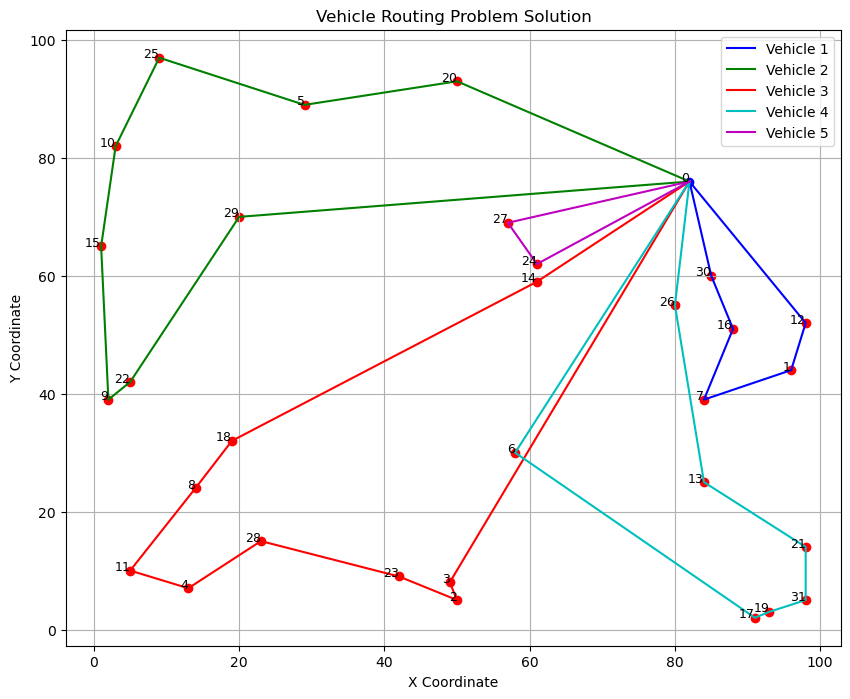

===================== (Augerat et al, No of trucks: 5, Optimal value: 669) =====================
Number of Nodes: 37
{'id': 'chatcmpl-BKIahIJAoylAJ7GTzmLIqTQgAAqPP', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': "To develop a node selection strategy for the Capacitated Vehicle Routing Problem (CVRP) with the goal of minimizing the total distance while keeping in mind the customer demands, we need to suitably weight the contributions of demands and distances.\n\nGiven the objective to minimize distance and the nature of the common routing challenges, we can make the following considerations for the weights:\n\n1. **Demand Weight (a)**: This should be relatively low since the objective is to minimize distance more than to balance the load or focus on demand. A suitable value could be around 0.2.\n\n2. **Distance Weight (b)**: This should be higher than the demand weight since the primary objective is to minimize distance traveled. A value like 1.0 would emphasize t

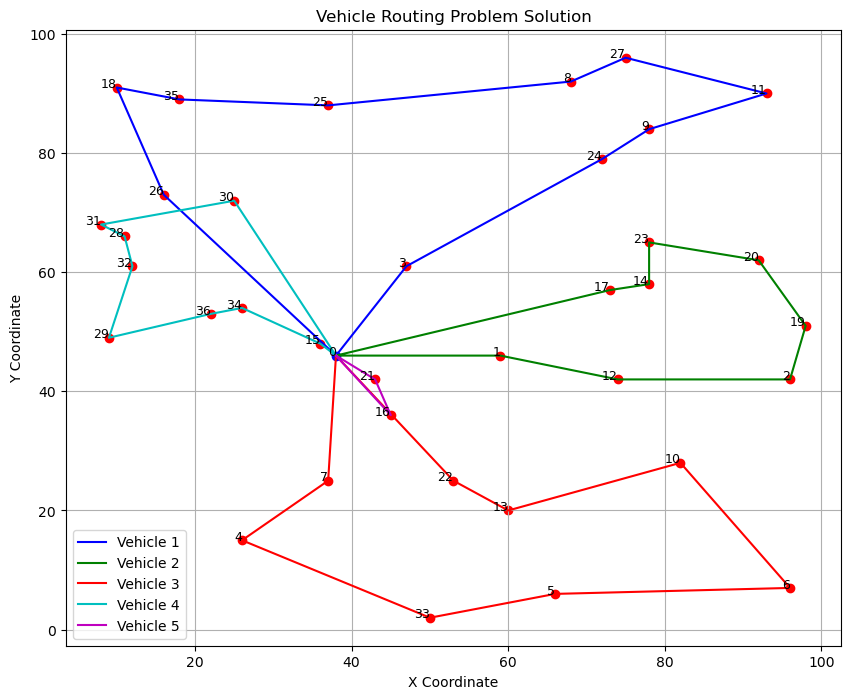

===================== (Augerat et al, No of trucks: 7, Optimal value: 1073) =====================
Number of Nodes: 48
{'id': 'chatcmpl-BKIbBrZlBUIJlJvwu9cta4k5cJAFl', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': "To tackle the Capacitated Vehicle Routing Problem (CVRP) with the given data, we want to minimize the total distance traveled by the vehicles while also considering the demands of the customers. The weights in the strategy will balance customer demand (to favor serving customers with lower demand), the distance from the current node to a customer (to favor closer customers), and a constant term (which can serve to normalize the scores).\n\nLet's assign the weights as follows:\n\n1. **Weight for Demand (`a`)**: A lower demand can be considered more favorable to ensure that we efficiently use vehicle capacity. In this context, we can assign a small positive weight to this, such as `-1.0`, encouraging the selection of nodes with lower demands since we're m

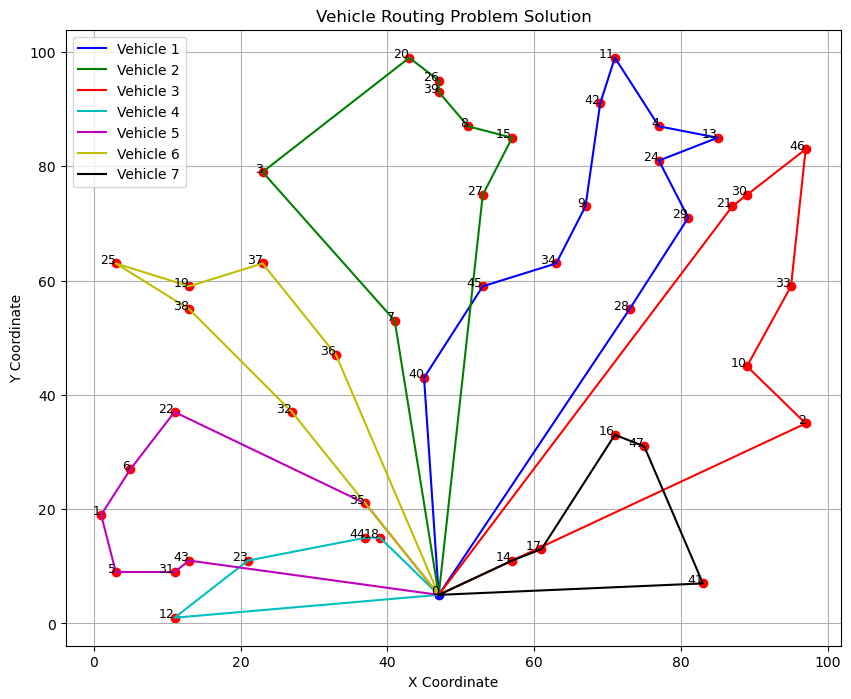

===================== (Augerat et al, No of trucks: 10, Optimal value: 696) =====================
Number of Nodes: 50
{'id': 'chatcmpl-BKIbhALWClzuPcJKSBNRZP9n21Pu6', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'To create a weight strategy that prioritizes minimizing the total distance traveled in the Capacitated Vehicle Routing Problem (CVRP), we can consider the three weight components as follows:\n\n1. **Customer Demand Weight (a)**: Since our aim is to minimize the total distance traveled, the weight assigned to customer demand can be relatively low. If we give this weight a smaller value, we ensure that the selection process is less influenced by demand compared to distance.\n\n2. **Distance Weight (b)**: This weight should be given the highest value, as the main objective is to minimize the distance. By making this weight much larger, we ensure that the algorithm favors nodes that are closer to the current vehicle location.\n\n3. **Constant Weight (c)**: 

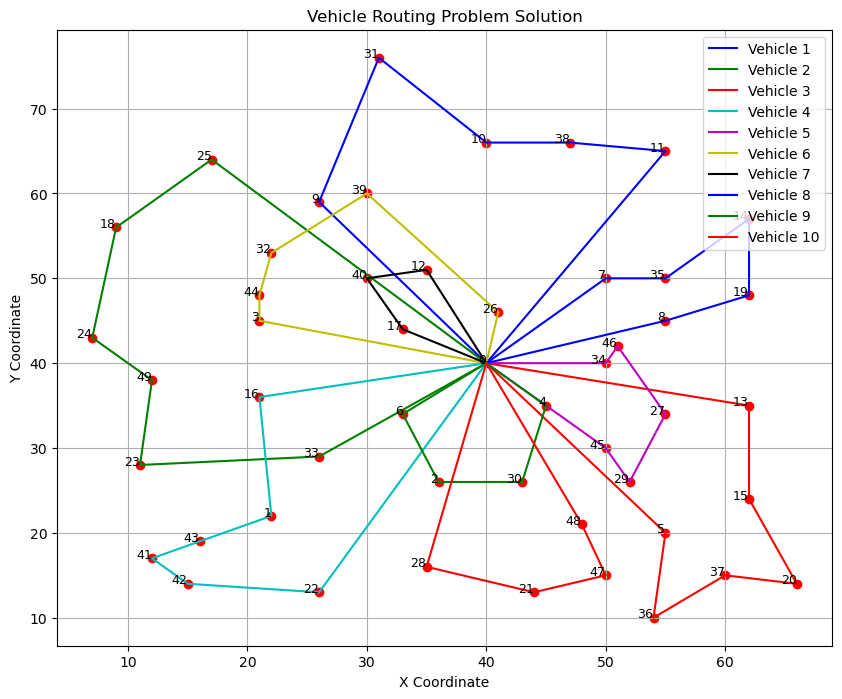

In [16]:


if __name__ == "__main__":
    root_folder = './data/cvrp/small'
    cvrp_instances = read_all_instances(root_folder, ending='.vrp')

    global_best_cost = float('inf')
    global_best_routes = None
    global_best_strategy = None
    global_best_instance_name = None

    with open('results.txt_small', 'w') as f:
        for i in range(len(cvrp_instances)):
            cvrp_instance = cvrp_instances[i]
            vehicle_capacity = cvrp_instance['capacity']
            demands = cvrp_instance['demand']
            distance_matrix = [[int(value) for value in row] for row in cvrp_instance['edge_weight']]
            node_coords = cvrp_instance['node_coord']
            instance_name = cvrp_instance['comment']
            f.write(f"===================== {instance_name} =====================\n")
            
            print("=====================", instance_name, "=====================")
            match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))
            if match:
                num_vehicles = int(match.group(1))
            else:
                match_min_no_of_trucks = re.search(r"Min no of trucks: (\d+)", str(cvrp_instance['comment']))
                if match_min_no_of_trucks:
                    num_vehicles = int(match_min_no_of_trucks.group(1))
                else:
                    num_vehicles = None

            num_nodes = len(node_coords)
            data_detail_dict = {
                    "instance_name": instance_name,
                    "vehicle_capacity": vehicle_capacity,
                    "demand_distribution": {
                        "min_demand": min(demands),
                        "max_demand": max(demands),
                  
                    },
                    "distance_matrix_properties": {
                        "min_distance": min([min(row) for row in distance_matrix]) if distance_matrix else 0,
                        "max_distance": max([max(row) for row in distance_matrix]) if distance_matrix else 0,
                        "average_distance": sum([sum(row) for row in distance_matrix]) / (len(distance_matrix) * len(distance_matrix[0])) if distance_matrix else 0
                    },
                    "num_vehicles": num_vehicles,
                    "num_nodes": num_nodes
                }
            print("Number of Nodes:", num_nodes)
            best_routes, best_cost, best_strategy, all_strategy_results = funsearch(distance_matrix, demands, num_vehicles, vehicle_capacity,data_detail_dict )
            print("Best routes found:", best_routes)
            print("Best total distance:", best_cost)
            print("Best strategy:", best_strategy)
            test_capacity_constraint(best_routes, demands, vehicle_capacity)
            plot_CVRP_solution(best_routes, node_coords)

            f.write(f"Best routes found: {best_routes}\n")
            f.write(f"Best total distance: {best_cost}\n")
            f.write(f"Best strategy: {best_strategy}\n")

            f.write("\nLLM Strategy Results:\n")
            for strategy, cost in all_strategy_results:
                f.write(f"Strategy: {strategy}, Cost: {cost}\n")



Successfully read A-n53-k7.vrp
Successfully read A-n63-k10.vrp
Successfully read P-n65-k10.vrp
Successfully read A-n80-k10.vrp
Successfully read E-n76-k14.vrp
===================== (Augerat et al, No of trucks: 7, Optimal value: 1010) =====================
Number of Nodes: 53
{'id': 'chatcmpl-BKIfcfbFGPAn15OY48zYzfy5U5ksX', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': "To generate an effective node selection strategy for the Capacitated Vehicle Routing Problem (CVRP) that aims to minimize total distance while also considering customer demand, it's crucial to balance these two factors appropriately. Given the problem characteristics, including the number of vehicles, vehicle capacity, and demand range, we can assign weights to prioritize distance over demand.\n\nConsidering the data provided, we have:\n\n- Vehicle capacity: 100\n- Demand range: 0 to 30\n- A total of 7 vehicles for 53 nodes\n\nSince the goal is to minimize distance, we should assign a higher weigh

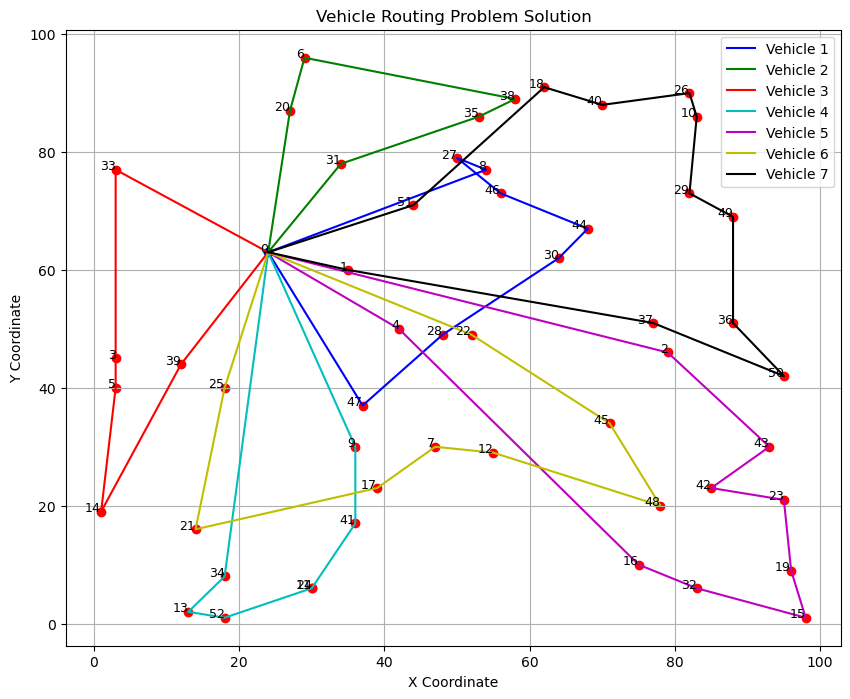

===================== (Augerat et al, No of trucks: 10, Optimal value: 1314) =====================
Number of Nodes: 63
{'id': 'chatcmpl-BKIfyrZjANT8Dm66mSlF2gq0mzA5z', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'In the context of the Capacitated Vehicle Routing Problem (CVRP), where the main goal is to minimize the total travel distance while considering the vehicle capacity constraints and customer demands, it’s crucial to balance the competing objectives represented by customer demand and distance in a way that drives effective route selection.\n\nGiven your preference to minimize total distance, I recommend the following weights for the strategy:\n\n- **Weight for Demand (a)**: This should be low since we prioritize minimizing distance over demand.\n- **Weight for Distance (b)**: This should be relatively high, as you want to emphasize shorter distances.\n- **Weight for Constant (c)**: This can be set to 0 since it does not affect the relative scoring betwe

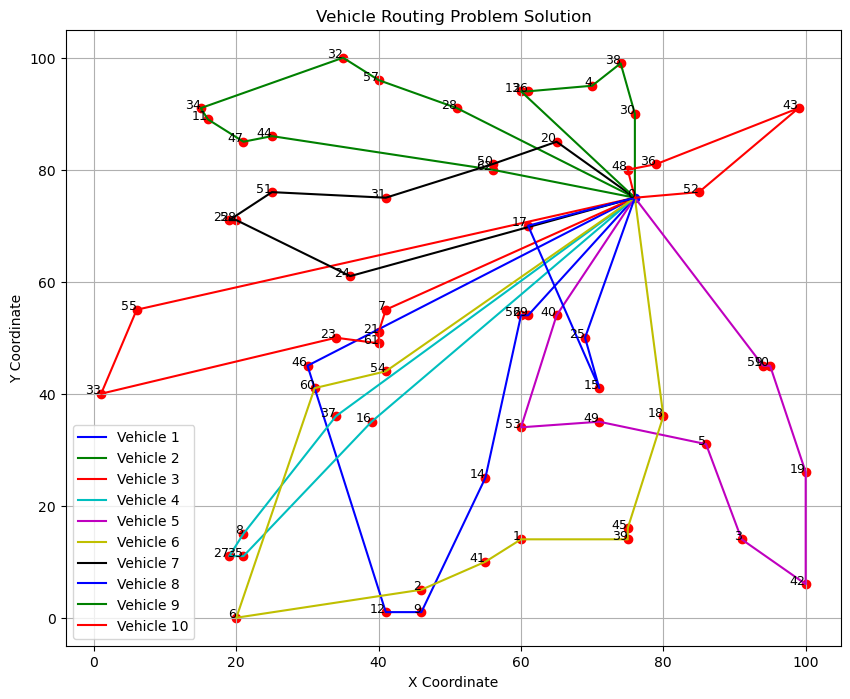

===================== (Augerat et al, No of trucks: 10, Optimal value: 792) =====================
Number of Nodes: 65
{'id': 'chatcmpl-BKIgJcrfPmFjTOQ9cuz9SSTf5E5AX', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'To develop a node selection strategy for the Capacitated Vehicle Routing Problem (CVRP) that aims to minimize the total distance while taking into account customer demand, we need to set weights for the three components: customer demand, distance to the customer, and a constant term. \n\nGiven the characteristics of your instance:\n- Number of vehicles: **10**\n- Vehicle capacity: **130**\n- Demand distribution (minimum: **0**, maximum: **37**)\n- Minimum distance: **0**, maximum distance: **85**, average distance: **32.13**\n\nIn a scenario where the goal is to minimize total distance, we need to ensure that the weights reflect this priority. We also need to consider the demand so that we do not overload the vehicles, while the constant term can help a

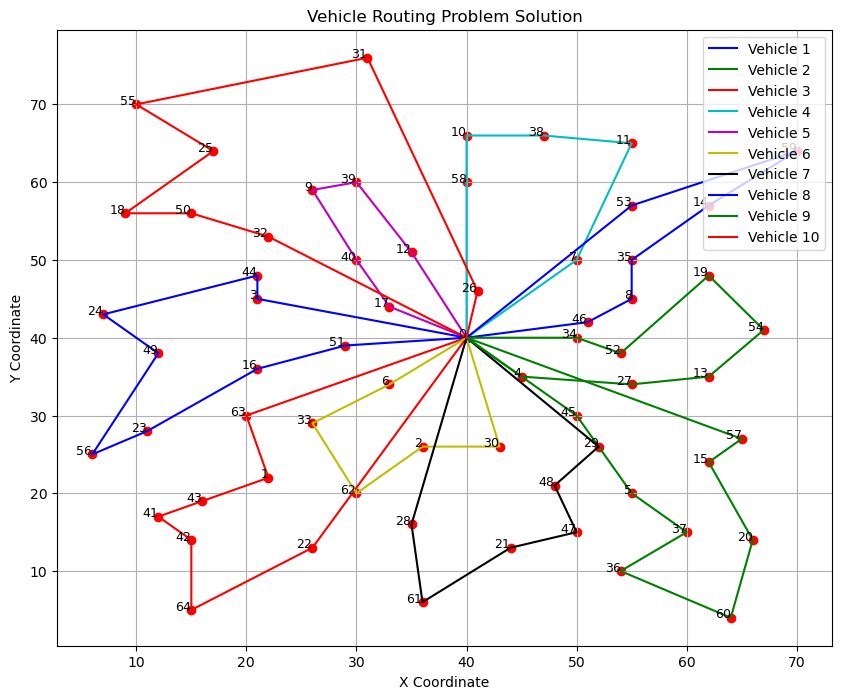

===================== (Augerat et al, No of trucks: 10, Optimal value: 1763) =====================
Number of Nodes: 80
{'id': 'chatcmpl-BKIgjzwKdruqxQZX5jL4cFJfKZiHV', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': "To create a node selection strategy in the context of the Capacitated Vehicle Routing Problem (CVRP) for the given data, where the goal is to minimize the total distance travelled, we can assign weights designed to emphasize the importance of distance over demand.\n\nGiven the data characteristics:\n- **Vehicle Capacity**: 100\n- **Demand Distribution**: Max demand is 26, meaning there's a relatively low level of demand per node.\n- **Distance Matrix Properties**: Average distance is about 50.69, with a maximum of 137.\n\nConsidering the goal is to minimize the total distance travelled, we can assign the weights for the strategy in a way that prioritizes minimizing distance while still accounting for demand to a lesser extent.\n\nLet’s consider the wei

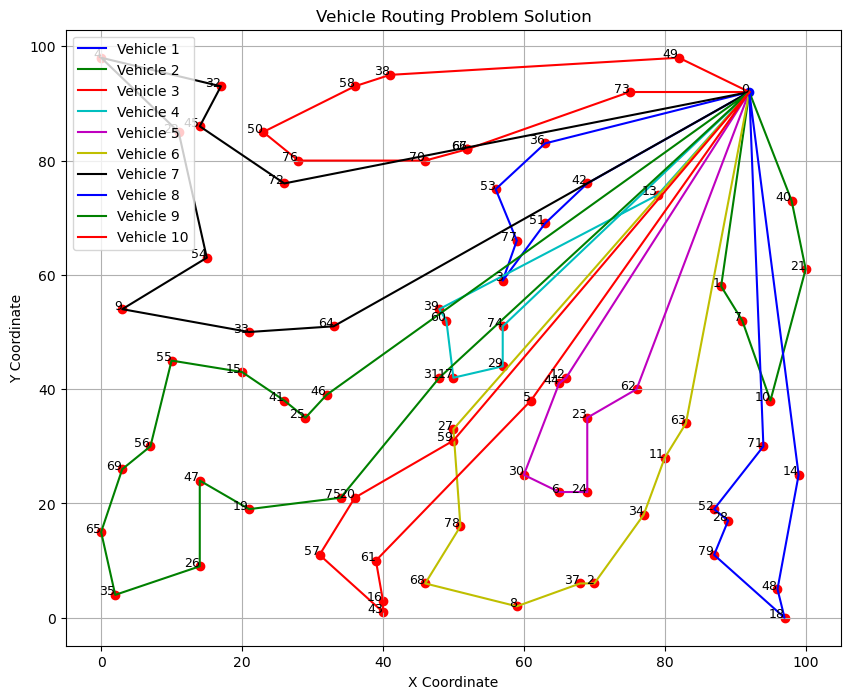

===================== (Christophides and Eilon, Min no of trucks: 14, Optimal value: 1021) =====================
Number of Nodes: 76
{'id': 'chatcmpl-BKIh3RTOn41MVzt0KNWgncRBLE8h6', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': "To create a node selection strategy for the Capacitated Vehicle Routing Problem (CVRP), which prioritizes minimizing the total distance while considering the customer demands, it is important to set the weight coefficients strategically based on the characteristics of the problem.\n\nGiven the context where:\n- You want to minimize the total distance,\n- The vehicle capacity is 100,\n- The demand distribution has a maximum of 37,\n- There are 14 vehicles and 76 nodes (including the depot),\n- The distance matrix has an average distance of approximately 32.4,\n\nI suggest the following weights:\n\n1. **Weight for demand (a)**: This weight should be relatively low since you want to prioritize distance minimization. A value of `-1` discourag

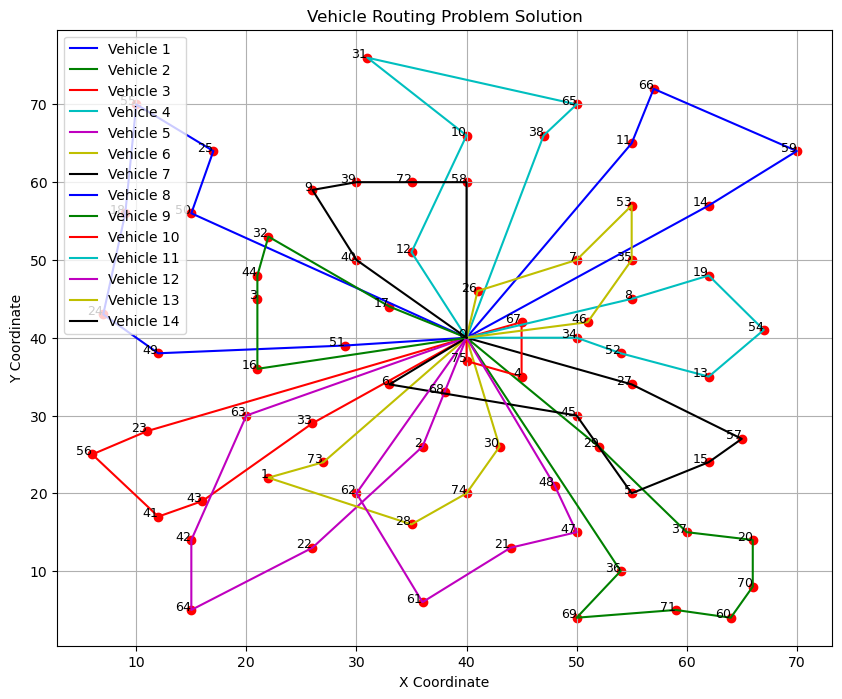

In [17]:
if __name__ == "__main__":
    root_folder = './data/cvrp/medium'
    cvrp_instances = read_all_instances(root_folder, ending='.vrp')

    global_best_cost = float('inf')
    global_best_routes = None
    global_best_strategy = None
    global_best_instance_name = None

    with open('results_medium.txt', 'w') as f:
        for i in range(len(cvrp_instances)):
            cvrp_instance = cvrp_instances[i]
            vehicle_capacity = cvrp_instance['capacity']
            demands = cvrp_instance['demand']
            distance_matrix = [[int(value) for value in row] for row in cvrp_instance['edge_weight']]
            node_coords = cvrp_instance['node_coord']
            instance_name = cvrp_instance['comment']
            f.write(f"===================== {instance_name} =====================\n")
            
            print("=====================", instance_name, "=====================")
            match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))
            if match:
                num_vehicles = int(match.group(1))
            else:
                match_min_no_of_trucks = re.search(r"Min no of trucks: (\d+)", str(cvrp_instance['comment']))
                if match_min_no_of_trucks:
                    num_vehicles = int(match_min_no_of_trucks.group(1))
                else:
                    num_vehicles = None

            num_nodes = len(node_coords)
            data_detail_dict = {
                    "instance_name": instance_name,
                    "vehicle_capacity": vehicle_capacity,
                    "demand_distribution": {
                        "min_demand": min(demands),
                        "max_demand": max(demands),
                  
                    },
                    "distance_matrix_properties": {
                        "min_distance": min([min(row) for row in distance_matrix]) if distance_matrix else 0,
                        "max_distance": max([max(row) for row in distance_matrix]) if distance_matrix else 0,
                        "average_distance": sum([sum(row) for row in distance_matrix]) / (len(distance_matrix) * len(distance_matrix[0])) if distance_matrix else 0
                    },
                    "num_vehicles": num_vehicles,
                    "num_nodes": num_nodes
                }
            print("Number of Nodes:", num_nodes)
            best_routes, best_cost, best_strategy, all_strategy_results = funsearch(distance_matrix, demands, num_vehicles, vehicle_capacity,data_detail_dict )
            print("Best routes found:", best_routes)
            print("Best total distance:", best_cost)
            print("Best strategy:", best_strategy)
            test_capacity_constraint(best_routes, demands, vehicle_capacity)
            plot_CVRP_solution(best_routes, node_coords)

            f.write(f"Best routes found: {best_routes}\n")
            f.write(f"Best total distance: {best_cost}\n")
            f.write(f"Best strategy: {best_strategy}\n")

            f.write("\nLLM Strategy Results:\n")
            for strategy, cost in all_strategy_results:
                f.write(f"Strategy: {strategy}, Cost: {cost}\n")


Successfully read X-n120-k6.vrp
Successfully read X-n115-k10.vrp
Successfully read X-n139-k10.vrp
Successfully read X-n110-k13.vrp
===================== "Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013),, Min no of trucks: 6" =====================
Number of Nodes: 120
{'id': 'chatcmpl-BKIhzYbVHI2UsMI4H16RaFzbHMg60', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'To generate a node selection strategy for the Capacitated Vehicle Routing Problem (CVRP) with the aim of minimizing total distance while also taking into account customer demand, we can assign weights to the components of the score function in the `generate_new_solution` code.\n\nGiven your problem characteristics:\n1. **Vehicle Capacity**: 21\n2. **Demand**: Ranges from 0 to 1 (very lightweight)\n3. **Distance Matrix**: Average distance is around 509.65 with a maximum of 1320.\n\nSince you want to prioritize minimizing distance, we can assign a relatively high weight to the distanc

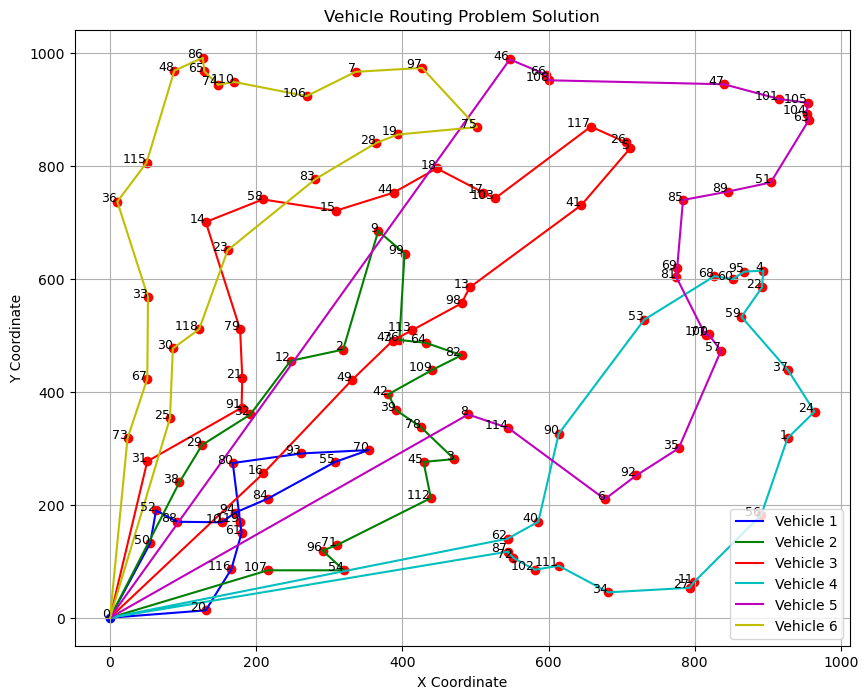

===================== "Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013), Min no of trucks: 10" =====================
Number of Nodes: 115
{'id': 'chatcmpl-BKIiRCuOc6QoMazHtR2hujoeNFu45', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': "To create a node selection strategy for the Capacitated Vehicle Routing Problem (CVRP) that aims to minimize total distance, we need to carefully balance the influence of customer demand and travel distances. Given the characteristics of the problem described:\n\n- Vehicle capacity is 169.\n- Demand distribution ranges from 0 to 99.\n- There are 10 vehicles and a total of 115 nodes, including the depot.\n- The distance matrix has maximum distances of 1262 and an average of approximately 494.32.\n\nTo emphasize the minimization of total distance while still considering customer demand, we can assign weight values as follows:\n\n1. **Weight for Demand (a)**: A smaller value is typically beneficial here since we w

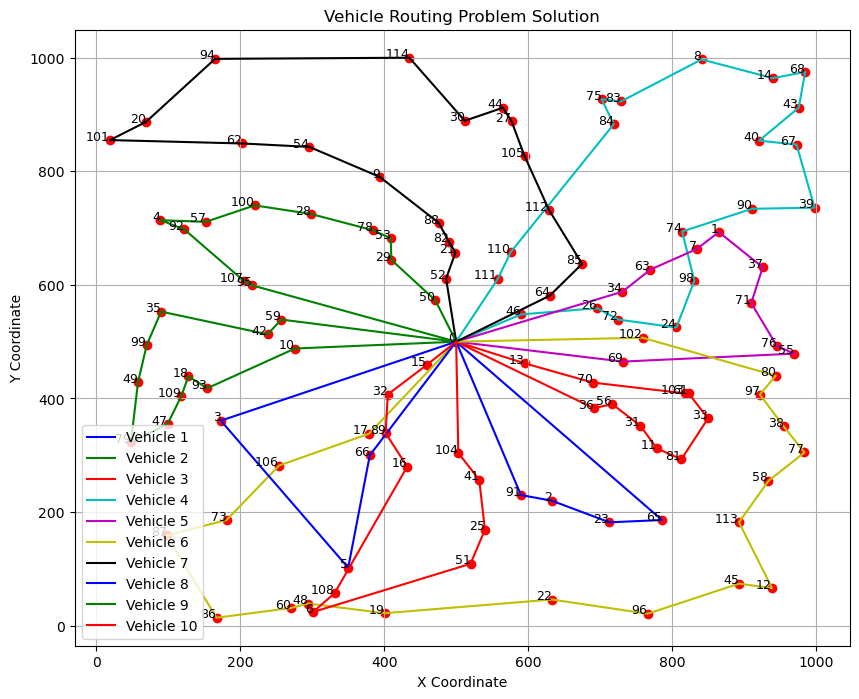

===================== "Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013), Min no of trucks: 10" =====================
Number of Nodes: 139
{'id': 'chatcmpl-BKIip0J1EKaQmLMdBoM4XWPdNZa3E', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'To develop a node selection strategy for the Capacitated Vehicle Routing Problem (CVRP) that minimizes total distance, we need to set the weights for customer demand, distance to the customer, and a constant term.\n\nGiven the context of your problem, I recommend the following approach to assign the weights:\n\n1. **Weight for Demand (a)**: Since we want to minimize total distance traveled, we should give a lower weight to customer demand. This lets us focus more on selecting nearer customers, especially since the demand is relatively low compared to the distances involved. A weight of `1` can be used for demand.\n\n2. **Weight for Distance (b)**: This weight should be significantly higher than the weight for d

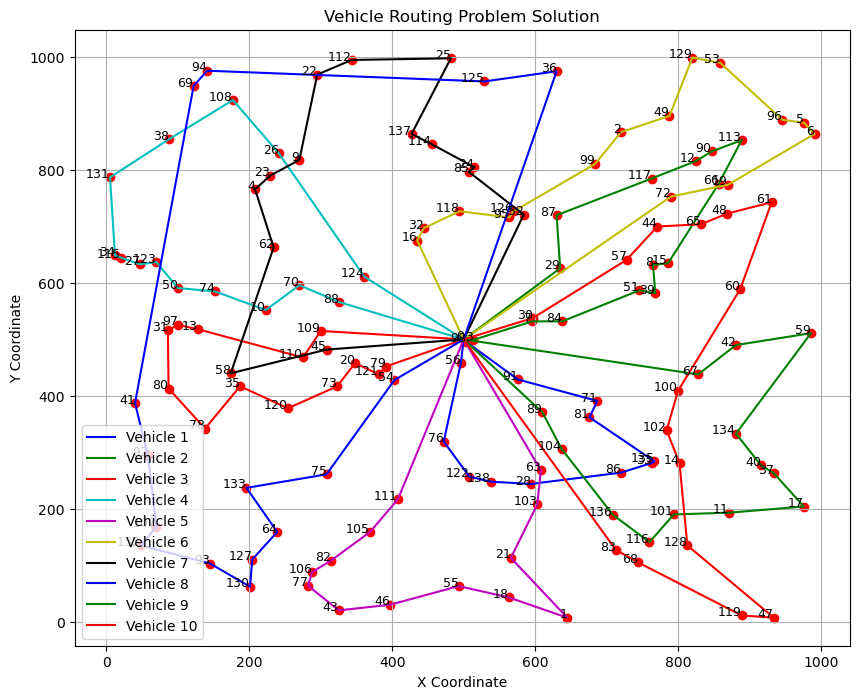

===================== "Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013),Min no of trucks: 13" =====================
Number of Nodes: 110
{'id': 'chatcmpl-BKIjKwQnDQC16SKUhu69ghQBDynPW', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': 'To create a node selection strategy that prioritizes minimizing the total distance while considering customer demand, we can set up weights for each of the components: customer demand, distance from the current node to the customer, and a constant value. Given that you want to minimize the total distance as much as possible, we can assign these weights to reflect that preference.\n\nA reasonable approach could be:\n\n- Since your main goal is to minimize distance, we can assign a higher weight to the distance component.\n- The demand should hold some significance, but since you want to minimize the total distance, the weight for demand can be lower.\n- The constant value can be set to zero; it does not impact th

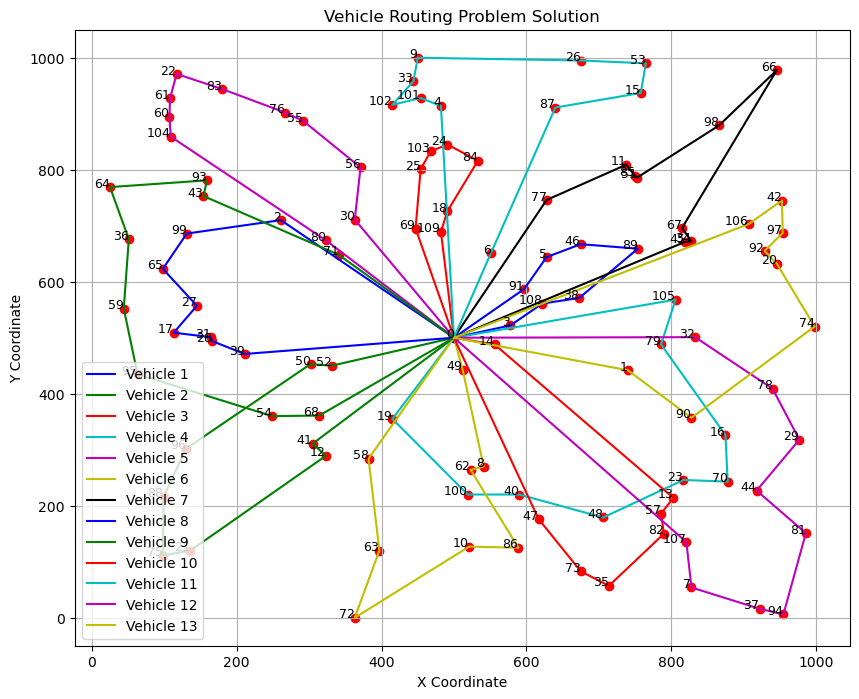

In [18]:
if __name__ == "__main__":
    root_folder = './data/cvrp/large'
    cvrp_instances = read_all_instances(root_folder, ending='.vrp')

    global_best_cost = float('inf')
    global_best_routes = None
    global_best_strategy = None
    global_best_instance_name = None

    with open('results_large.txt', 'w') as f:
        for i in range(len(cvrp_instances)):
            cvrp_instance = cvrp_instances[i]
            vehicle_capacity = cvrp_instance['capacity']
            demands = cvrp_instance['demand']
            distance_matrix = [[int(value) for value in row] for row in cvrp_instance['edge_weight']]
            node_coords = cvrp_instance['node_coord']
            instance_name = cvrp_instance['comment']
            f.write(f"===================== {instance_name} =====================\n")
            
            print("=====================", instance_name, "=====================")
            match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))
            if match:
                num_vehicles = int(match.group(1))
            else:
                match_min_no_of_trucks = re.search(r"Min no of trucks: (\d+)", str(cvrp_instance['comment']))
                if match_min_no_of_trucks:
                    num_vehicles = int(match_min_no_of_trucks.group(1))
                else:
                    num_vehicles = None

            num_nodes = len(node_coords)
            data_detail_dict = {
                    "instance_name": instance_name,
                    "vehicle_capacity": vehicle_capacity,
                    "demand_distribution": {
                        "min_demand": min(demands),
                        "max_demand": max(demands),
                  
                    },
                    "distance_matrix_properties": {
                        "min_distance": min([min(row) for row in distance_matrix]) if distance_matrix else 0,
                        "max_distance": max([max(row) for row in distance_matrix]) if distance_matrix else 0,
                        "average_distance": sum([sum(row) for row in distance_matrix]) / (len(distance_matrix) * len(distance_matrix[0])) if distance_matrix else 0
                    },
                    "num_vehicles": num_vehicles,
                    "num_nodes": num_nodes
                }
            print("Number of Nodes:", num_nodes)
            best_routes, best_cost, best_strategy, all_strategy_results = funsearch(distance_matrix, demands, num_vehicles, vehicle_capacity,data_detail_dict )
            print("Best routes found:", best_routes)
            print("Best total distance:", best_cost)
            print("Best strategy:", best_strategy)
            test_capacity_constraint(best_routes, demands, vehicle_capacity)
            plot_CVRP_solution(best_routes, node_coords)

            f.write(f"Best routes found: {best_routes}\n")
            f.write(f"Best total distance: {best_cost}\n")
            f.write(f"Best strategy: {best_strategy}\n")

            f.write("\nLLM Strategy Results:\n")
            for strategy, cost in all_strategy_results:
                f.write(f"Strategy: {strategy}, Cost: {cost}\n")
